# COGS 108 - EDA Checkpoint

# Names

- Crystal Zhan
- Akil Selvan Rajendra Janarthanan 
- Kristen Prescaro
- Kristine Thipatima
- Ethan Dinh-Luong

<a id='research_question'></a>
# Research Question

How did the addition of the Fairy type Pokemon change competitive battling?

# Setup

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

## Cleaning Informational Data (Pokemon Moves, Pokemon Types)

The list of moves is in a semi-structed JSON file, which we needed to clean up so we only had the relevant information about the moves. 

In [8]:
moves = pd.read_json("Pokedex and Moves/data/moves.json")
moves.head()

,10000000voltthunderbolt,absorb,accelerock,acid,acidarmor,aciddownpour,acidspray,acrobatics,acupressure,aerialace,...,workup,worryseed,wrap,wringout,xscissor,yawn,zapcannon,zenheadbutt,zingzap,zippyzap
num,719,71,709,51,151,628,491,512,367,332,...,526,388,35,378,404,281,192,428,716,729
accuracy,True,100,100,100,True,True,100,100,True,True,...,True,100,90,100,100,True,50,90,100,100
basePower,195,20,40,40,0,1,40,55,0,60,...,0,0,15,0,80,0,120,80,80,80
category,Special,Special,Physical,Special,Status,Physical,Special,Physical,Status,Physical,...,Status,Status,Physical,Special,Physical,Status,Special,Physical,Physical,Physical
isNonstandard,Past,NaN,NaN,NaN,NaN,Past,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Past,NaN,NaN,NaN,NaN,NaN,LGPE


As can be seen, the names of the moves are the column names and the variables are the row names. However, we want it the other way around, with the move names as the index. 

We also only want the move name and the move type, so we remove all other variables. 

Next, we reset the index so there are index numbers and rename the index column to be called move.

Now, our move dataset is clean. 

In [4]:
# switching the column and row names 
moves = moves.T

# removing all columns except move name & type
moves = moves.loc[:,["name", "type"]]

#resetting the index numbers
moves = moves.reset_index()

#renaming index to be called move 
moves.rename(columns = {"index":"move"}, inplace=True)
moves.head()

,move,name,type
0,10000000voltthunderbolt,"10,000,000 Volt Thunderbolt",Electric
1,absorb,Absorb,Grass
2,accelerock,Accelerock,Rock
3,acid,Acid,Poison
4,acidarmor,Acid Armor,Poison


Now, we apply the same cleaning steps with the list of Pokemon. 

However, there is an extra step of removing any Mega or Gmax form Pokemon, as our Pokemon Showdown dataset doesn't include them, nor would they affect the usage of Pokemon based on type. 

In [9]:
pokemon = pd.read_json("Pokedex and Moves/data/pokedex.json")

#takes column name and row name and flips them
pokemon = pokemon.T 
pokemon = pokemon.iloc[0:1155, :]

#deletes all columns except for name and types
pokemon = pokemon.loc[:,["name", "types"]]
pokemon = pokemon.reset_index()

#renames index to be pokemon
pokemon.rename(columns = {"index":"pokemon"}, inplace=True)

#drop rows that contain the partial string "gmax or mega" in the pokemon column
pokemon = pokemon[~pokemon.pokemon.str.contains("gmax")]
pokemon = pokemon[~pokemon.name.str.contains("-Mega")]

pokemon.head()


,pokemon,name,types
0,bulbasaur,Bulbasaur,"[Grass, Poison]"
1,ivysaur,Ivysaur,"[Grass, Poison]"
2,venusaur,Venusaur,"[Grass, Poison]"
5,charmander,Charmander,[Fire]
6,charmeleon,Charmeleon,[Fire]


The next step for the Pokemon list is to split the type column into two parts, as some Pokemon have two types, while others have one. For those with one type, we will put null for the 2nd type. 

In [10]:
type1 = []
type2 = []

#loop through the list of pokemon and puts their types in their own columns
#puts None if there's no secondary type
for x in pokemon["types"]:
    type1.append(x[0])
    if (len(x) == 2):
        type2.append(x[1])
    else:
        type2.append(None)

pokemon["types"] = type1
pokemon["type2"] = type2
pokemon.head()


,pokemon,name,types,type2
0,bulbasaur,Bulbasaur,Grass,Poison
1,ivysaur,Ivysaur,Grass,Poison
2,venusaur,Venusaur,Grass,Poison
5,charmander,Charmander,Fire,None
6,charmeleon,Charmeleon,Fire,None


## Pokemon Showdown Battle Stats

The data given by Pokemon Showdown is several semi-structured JSON format files, where cleaning was needed in every file to read the data into a usable format. 

*The cleaning process exampled below was repeated for all other JSON files.*

Unnecessary data prior to our analysis was removed where data was null.

In [11]:
raw = pd.read_json("Pokemon Usage/September/raw/gen8/gen8ou-0.json")
df = raw[raw['data'].notna()]['data']
df

Mr. Mime-Galar    {'Moves': {'': 32.0, 'healingwish': 226.0, 'bl...
Eevee             {'Moves': {'': 197.0, 'rest': 7.0, 'mudslap': ...
Torracat          {'Moves': {'': 1.0, 'firespin': 20.0, 'leechli...
Poliwrath         {'Moves': {'': 58.0, 'counter': 48.0, 'liquida...
Emolga            {'Moves': {'': 2.0, 'eerieimpulse': 47.0, 'ris...
                                        ...                        
Shedinja          {'Moves': {'': 578.0, 'absorb': 11.0, 'falsesw...
Wishiwashi        {'Moves': {'': 67.0, 'liquidation': 393.0, 'be...
Sneasel           {'Moves': {'counter': 3.0, 'beatup': 9.0, 'bli...
Hitmontop         {'Moves': {'': 208.0, 'detect': 89.0, 'quickgu...
Kingdra           {'Moves': {'': 57.0, 'icywind': 32.0, 'liquida...
Name: data, Length: 440, dtype: object

To narrow down the data desired for our analysis, the following criteria were used to filter out the data:
- Pokemon with at least 2% usage
- Each Pokemon's Top 6 Moves

Additionally, each dataframe includes 4 more columns identifying which JSON file the data originated from, denoted by **Gen**, **Format**, **Rating**, and **Recent** given in the first few rows of the JSON file.

In [13]:
### Dictionary to make the DataFrame
top_mons = {}

### Saves the Pokemon as Indexes
ix = list(df.index)

### For each Observation
for row in range(len(df)):

    ### At least 2% Usage
    if df[row]['usage'] >= .02:

        ### Pokemon Name
        mon = ix[row]

        ### Finds the Top 6 Moves
        top_6 = list(dict(sorted(df[row]['Moves'].items(), key=lambda item: item[1], reverse=True)))[:6]
        
        ### Saves info to dictionary
        top_mons[mon] = [top_6, df[row]['usage']]

### Output DataFrame
cleaned = pd.DataFrame.from_dict(top_mons, orient = 'index').rename(columns = {0:"Moves", 1:"Usage"})

### Format, Gen, Rating Variables
metagame = raw.loc['metagame'][0]
gen = metagame[3]
format_name = metagame[4:]
rating = raw.loc["cutoff"][0]

### Adding the Variables to the DF
cleaned["Gen"] = gen
cleaned["Format"] = format_name
cleaned["Min Rating"] = rating
cleaned.head()


,Moves,Usage,Gen,Format,Min Rating
Landorus-Therian,"[earthquake, uturn, stealthrock, knockoff, tox...",0.304108,8,ou,0.0
Blissey,"[softboiled, seismictoss, toxic, teleport, thu...",0.084829,8,ou,0.0
Slowbro,"[scald, teleport, slackoff, futuresight, icebe...",0.057747,8,ou,0.0
Crawdaunt,"[aquajet, knockoff, crabhammer, swordsdance, c...",0.028303,8,ou,0.0
Urshifu-Rapid-Strike,"[surgingstrikes, closecombat, aquajet, uturn, ...",0.129478,8,ou,0.0


## Joining the Datasets

### Showdown Usage with Moves

Firstly, we imported all the cleaned data from the prior section that was applied to all JSON files.

In [14]:
### Importing Usage DFs and Merging Them
recentdf = pd.read_csv("Pokemon Usage/SeptemberData.csv",index_col=0).rename(columns = {'index':"name"})
olddf =  pd.read_csv("Pokemon Usage/OldData.csv",index_col=0).rename(columns = {'index':"name"})
usagedf = recentdf.merge(olddf, how='outer')
print(usagedf.shape)
usagedf.head()

(5916, 7)


,name,Moves,Usage,Gen,Format,Min Rating,Recent
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1


The **Moves** column deceptively looks cleaned in a list format, but upon closer observation, it is actually a *string* representation of a list.

In [15]:
type(usagedf["Moves"][0])

str

Addressing this, we will convert the string into a list by stripping the list representation and splitting the string by commas. Afterwards, we can proceed with standardizing the moves by its type.

In [16]:
### Importing Moves DF
movesdf = pd.read_csv("Pokedex and Moves/moves.csv", index_col=0).set_index('move')

### Standardize the Moves
def standardize_moves(df):

    ### List Representations of each Column
    type1 = []
    type2 = []
    type3 = []
    type4 = []
    type5 = []
    type6 = []

    ### List of Pointers to Column Lists
    type_list = [type1, type2, type3, type4, type5, type6]

    ### For Each Row
    for row in range(len(df["Moves"])):

        ### Strip the List Borders and Create a List by Splitting on Commas in the String
        moves = df["Moves"][row].strip('][').split(', ')

        ### Tracks which Column Each Move Belongs to
        list_num = 0

        ### For Each Column
        for each in range(6):

            ### If a Pokemon has less than 6 moves, return nan
            if each >= len(moves):
                move_type = np.nan
                type_list[list_num].append(move_type)
                list_num += 1

            else:
                ### Removes Outer Apostrophes, if any
                string = moves[each].strip("'")

                ### If a Popular Move is an Empty Slot, return nan
                if (string) == "":
                    move_type = np.nan
                    type_list[list_num].append(move_type)
                    list_num += 1
                else:

                    ### Find Move in Move DF containing Type
                    move_type = movesdf.loc[string]['type']

                    ### Add to Column
                    type_list[list_num].append(move_type)

                    ### Change Column
                    list_num += 1

    ### Piecing Everything Together
    df["Type 1"] = type_list[0]
    df["Type 2"] = type_list[1]
    df["Type 3"] = type_list[2]
    df["Type 4"] = type_list[3]
    df["Type 5"] = type_list[4]
    df["Type 6"] = type_list[5]

    return df

usagemovesdf = standardize_moves(usagedf)
usagemovesdf.head()

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2,Type 3,Type 4,Type 5,Type 6
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Normal,Ground,Rock,Psychic,Water
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Ground,Rock,Water,Ice,Ice,Normal
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,Dark,Ground,Ghost,Psychic,Fire
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Rock,Bug,Electric,Psychic,Psychic,Psychic
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,Dark,Steel,Ice,Rock,Normal


### Showdown Usage with Pokemon Types

As opposed to the complexity of joining moves with usage, simply joining the Pokemon Types DF stats on the Showdown Usage on **name** will add two new columns **Type 1** and **Type 2** to the Showdown Usage DF.

In [12]:
### Import Usage Data
usagedf = recentdf.merge(olddf, how='outer')

### Import Pokemon Types Data
pokedexdf = pd.read_csv("Pokedex and Moves/pokemon.csv", index_col=0).set_index('name')[['types','type2']]

### Left Join Usage DF with Pokemon Types DF on "name" while renaming the additional columns
usagetypesdf = usagedf.join(pokedexdf, on="name").rename(columns={'types': "Type 1", "type2": "Type 2"})
usagetypesdf

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Psychic
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Water,Ground
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,NaN
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Psychic,NaN
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,NaN
...,...,...,...,...,...,...,...,...,...
5911,Charizard,"['solarbeam', 'fireblast', 'hurricane', 'airsl...",0.030482,8.0,ubers,0.0,0,Fire,Flying
5912,Shuckle,"['stickyweb', 'stealthrock', 'encore', 'finalg...",0.045773,8.0,ubers,0.0,0,Bug,Rock
5913,Hatterene,"['mysticalfire', 'psychic', 'dazzlinggleam', '...",0.026064,8.0,ubers,0.0,0,Psychic,Fairy
5914,Zacian-Crowned,"['behemothblade', 'playrough', 'swordsdance', ...",0.921806,8.0,ubers,0.0,0,Fairy,Steel


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [64]:
def SE_moves(move_type, df, col):
    if move_type == "Dragon":
        SE_moves = ["Ice","Dragon"]
    else:
        SE_moves = ["Steel","Poison"]

    is_SE = None
    for each in SE_moves:
        if is_SE is None:
            is_SE = (df[col] == each)*1
        else:
            is_SE += (df[col] == each)*1
    
    return is_SE


def find_all_SE(df):
    types = ["Dragon", "Fairy"]
    col = ["Type 1", "Type 2", "Type 3", "Type 4", "Type 5", "Type 6"]
    SE_col = ["SE Dragon", "SE Fairy"]

    for each in types:

        all_SE = None

        for col_name in col:

            if all_SE is None:
                all_SE = SE_moves(each, df, col_name)
            else:
                all_SE += SE_moves(each, df, col_name)

        ### Uncomment to change to binary results 
        # all_SE = (all_SE > 0) * 1
        df[SE_col[0]] = all_SE
        SE_col = SE_col[1:]
    
    return df

usagemovesdf = find_all_SE(usagemovesdf)
usagemovesdf.head()

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2,Type 3,Type 4,Type 5,Type 6,SE Dragon,SE Fairy
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Normal,Ground,Rock,Psychic,Water,0,1
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Ground,Rock,Water,Ice,Ice,Normal,2,0
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,Dark,Ground,Ghost,Psychic,Fire,0,0
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Rock,Bug,Electric,Psychic,Psychic,Psychic,0,0
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,Dark,Steel,Ice,Rock,Normal,1,1


In [22]:

test = usagetypesdf[(usagetypesdf['Type 1'] == 'Dragon') | (usagetypesdf['Type 2'] == 'Dragon')]

test2 = usagetypesdf[(usagetypesdf['Type 1'] != 'Dragon') & (usagetypesdf['Type 2'] != 'Dragon')]

#########################################3


ubersusage = usagetypesdf[(usagetypesdf["Format"] == "ubers")]

dubersusage = ubersusage[(ubersusage['Type 1'] == 'Dragon') | (ubersusage['Type 2'] == 'Dragon')]
nuberusage = ubersusage[(ubersusage['Type 1'] != 'Dragon') & (ubersusage['Type 2'] != 'Dragon')]


###############################################
#take name, usage, and make a new column that says if they're dragon or not dragon
ubersusage = dubersusage[["name", "Usage"]]
#uberusage["type"] = "Dragon"

dragon = usagetypesdf.loc[((usagetypesdf['Type 1']=='Dragon') | (usagetypesdf['Type 2']=='Dragon')), :]
dragon['Usage'].sum()





duberusage4 = test[(test["Gen"] == 4)]
nuberusage4 = test2[(test2["Gen"] == 4)]

#print(nuberusage4["Usage"].sum())
#duberusage4["Usage"].sum()

#sns.countplot(y = 'Type', data = duberusage4);

duberusage4



NameError: name 'usagetypesdf' is not defined

In [21]:
gen4uber = usagetypesdf[usagetypesdf["Gen"] == 4.0][usagetypesdf["Format"] == 'ubers']
dragon4 = gen4uber.loc[((gen4uber['Type 1']=='Dragon') | (gen4uber['Type 2']=='Dragon')), :]
dragon4ubusage = dragon4['Usage'].sum()
notdragon4 = gen4uber.loc[((gen4uber['Type 1']!='Dragon') & (gen4uber['Type 2']!='Dragon')), :]
notdragon4ubusage = notdragon4['Usage'].sum()

gen5uber = usagetypesdf[usagetypesdf["Gen"] == 5.0][usagetypesdf["Format"] == 'ubers']
dragon5 = gen5uber.loc[((gen5uber['Type 1']=='Dragon') | (gen5uber['Type 2']=='Dragon')), :]
dragon5ubusage = dragon5['Usage'].sum()
notdragon5 = gen5uber.loc[((gen5uber['Type 1']!='Dragon') & (gen5uber['Type 2']!='Dragon')), :]
notdragon5ubusage = notdragon5['Usage'].sum()

gen6uber = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ubers']
dragon6 = gen6uber.loc[((gen6uber['Type 1']=='Dragon') | (gen6uber['Type 2']=='Dragon')), :]
dragon6ubusage = dragon6['Usage'].sum()
notdragon6 = gen6uber.loc[((gen6uber['Type 1']!='Dragon') & (gen6uber['Type 2']!='Dragon')), :]
notdragon6ubusage = notdragon6['Usage'].sum()

gen7uber = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ubers']
dragon7 = gen7uber.loc[((gen7uber['Type 1']=='Dragon') | (gen7uber['Type 2']=='Dragon')), :]
dragon7ubusage = dragon7['Usage'].sum()
notdragon7 = gen7uber.loc[((gen7uber['Type 1']!='Dragon') & (gen7uber['Type 2']!='Dragon')), :]
notdragon7ubusage = notdragon7['Usage'].sum()

gen8uber = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ubers']
dragon8 = gen8uber.loc[((gen8uber['Type 1']=='Dragon') | (gen8uber['Type 2']=='Dragon')), :]
dragon8ubusage = dragon8['Usage'].sum()
notdragon8 = gen8uber.loc[((gen8uber['Type 1']!='Dragon') & (gen8uber['Type 2']!='Dragon')), :]
notdragon8ubusage = notdragon8['Usage'].sum()

uberdragondf= pd.DataFrame(
    {
        "Gen 4": [dragon4usage, notdragon4usage],
        "Gen 5": [dragon5usage, notdragon5usage],
        "Gen 6": [dragon6usage, notdragon6usage],
        "Gen 7": [dragon7usage, notdragon7usage],
        "Gen 8": [dragon8usage, notdragon8usage]
    },
    index=["Dragon", "Not Dragon",]
)
uberdragondf

NameError: name 'usagetypesdf' is not defined

In [43]:
gen4ou = usagetypesdf[usagetypesdf["Gen"] == 4.0][usagetypesdf["Format"] == 'ou']
dragon4ou = gen4ou.loc[((gen4ou['Type 1']=='Dragon') | (gen4ou['Type 2']=='Dragon')), :]
dragon4ouusage = dragon4ou['Usage'].sum()
notdragon4ou = gen4ou.loc[((gen4ou['Type 1']!='Dragon') & (gen4ou['Type 2']!='Dragon')), :]
notdragon4ouusage = notdragon4ou['Usage'].sum()

gen5ou = usagetypesdf[usagetypesdf["Gen"] == 5.0][usagetypesdf["Format"] == 'ou']
dragon5ou = gen5ou.loc[((gen5ou['Type 1']=='Dragon') | (gen5ou['Type 2']=='Dragon')), :]
dragon5ouusage = dragon5ou['Usage'].sum()
notdragon5ou = gen5ou.loc[((gen5ou['Type 1']!='Dragon') & (gen5ou['Type 2']!='Dragon')), :]
notdragon5ouusage = notdragon5ou['Usage'].sum()

gen6ou = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ou']
dragon6ou = gen6ou.loc[((gen6ou['Type 1']=='Dragon') | (gen6ou['Type 2']=='Dragon')), :]
dragon6ouusage = dragon6ou['Usage'].sum()
notdragon6ou = gen6ou.loc[((gen6ou['Type 1']!='Dragon') & (gen6ou['Type 2']!='Dragon')), :]
notdragon6ouusage = notdragon6ou['Usage'].sum()

gen7ou = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ou']
dragon7ou = gen7ou.loc[((gen7ou['Type 1']=='Dragon') | (gen7ou['Type 2']=='Dragon')), :]
dragon7ouusage = dragon7ou['Usage'].sum()
notdragon7ou = gen7ou.loc[((gen7ou['Type 1']!='Dragon') & (gen7ou['Type 2']!='Dragon')), :]
notdragon7ouusage = notdragon7ou['Usage'].sum()

gen8ou = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ou']
dragon8ou = gen8ou.loc[((gen8ou['Type 1']=='Dragon') | (gen8ou['Type 2']=='Dragon')), :]
dragon8ouusage = dragon8ou['Usage'].sum()
notdragon8ou = gen8ou.loc[((gen8ou['Type 1']!='Dragon') & (gen8ou['Type 2']!='Dragon')), :]
notdragon8ouusage = notdragon8ou['Usage'].sum()

oudragondf= pd.DataFrame(
    {
        "Gen 4": [dragon4ouusage, notdragon4ouusage],
        "Gen 5": [dragon5ouusage, notdragon5ouusage],
        "Gen 6": [dragon6ouusage, notdragon6ouusage],
        "Gen 7": [dragon7ouusage, notdragon7ouusage],
        "Gen 8": [dragon8ouusage, notdragon8ouusage]
    },
    index=["Dragon", "Not Dragon",]
)
oudragondf = oudragondf.reset_index()
oudragondf

<ipython-input-43-bf11b50e81f8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen4ou = usagetypesdf[usagetypesdf["Gen"] == 4.0][usagetypesdf["Format"] == 'ou']
<ipython-input-43-bf11b50e81f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen5ou = usagetypesdf[usagetypesdf["Gen"] == 5.0][usagetypesdf["Format"] == 'ou']
<ipython-input-43-bf11b50e81f8>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen6ou = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ou']
<ipython-input-43-bf11b50e81f8>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen7ou = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ou']
<ipython-input-43-bf11b50e81f8>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen8ou = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ou']


,index,Gen 4,Gen 5,Gen 6,Gen 7,Gen 8
0,Dragon,4.613904,7.323489,4.450488,2.680142,5.558797
1,Not Dragon,41.920883,35.545149,34.704738,55.818660,55.720725


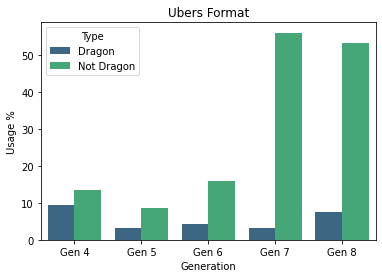

In [86]:
ubdragondf2= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Not Dragon', 'Dragon', 'Not Dragon','Dragon', 'Not Dragon','Dragon', 'Not Dragon', 'Dragon', 'Not Dragon'],
        "Usage %": [dragon4ubusage, notdragon4ubusage, dragon5ubusage, notdragon5ubusage, dragon6ubusage, notdragon6ubusage, dragon7ubusage, notdragon7ubusage,dragon8ubusage, notdragon8ubusage],
    },
)
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ubdragondf2,
            palette='viridis'
           ).set_title("Ubers Format");


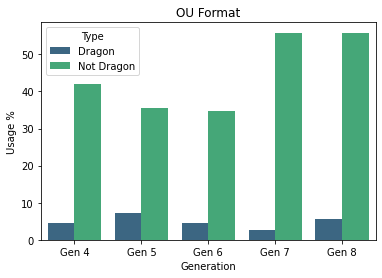

In [87]:
oudragondf2= pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4', 'Gen 5', 'Gen 5', 'Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Dragon', 'Not Dragon', 'Dragon', 'Not Dragon','Dragon', 'Not Dragon','Dragon', 'Not Dragon', 'Dragon', 'Not Dragon'],
        "Usage %": [dragon4ouusage, notdragon4ouusage, dragon5ouusage, notdragon5ouusage, dragon6ouusage, notdragon6ouusage, dragon7ouusage, notdragon7ouusage,dragon8ouusage, notdragon8ouusage],
    },
)
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=oudragondf2,
            palette='viridis'
           ).set_title("OU Format");


In [82]:
gen6ub = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ubers']
Fairy6ub = gen6ub.loc[((gen6ub['Type 1']=='Fairy') | (gen6ub['Type 2']=='Fairy')), :]
Fairy6ubusage = Fairy6ub['Usage'].sum()
notFairy6ub = gen6ub.loc[((gen6ub['Type 1']!='Fairy') & (gen6ub['Type 2']!='Fairy')), :]
notFairy6ubusage = notFairy6ub['Usage'].sum()

gen7ub = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ubers']
Fairy7ub = gen7ub.loc[((gen7ub['Type 1']=='Fairy') | (gen7ub['Type 2']=='Fairy')), :]
Fairy7ubusage = Fairy7ub['Usage'].sum()
notFairy7ub = gen7ub.loc[((gen7ub['Type 1']!='Fairy') & (gen7ub['Type 2']!='Fairy')), :]
notFairy7ubusage = notFairy7ub['Usage'].sum()

gen8ub = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ubers']
Fairy8ub = gen8ub.loc[((gen8ub['Type 1']=='Fairy') | (gen8ub['Type 2']=='Fairy')), :]
Fairy8ubusage = Fairy8ub['Usage'].sum()
notFairy8ub = gen8ub.loc[((gen8ub['Type 1']!='Fairy') & (gen8ub['Type 2']!='Fairy')), :]
notFairy8ubusage = notFairy8ub['Usage'].sum()

ubFairydf= pd.DataFrame(
    {
        "Gen 6": [Fairy6ubusage, notFairy6ubusage],
        "Gen 7": [Fairy7ubusage, notFairy7ubusage],
        "Gen 8": [Fairy8ubusage, notFairy8ubusage]
    },
    index=["Fairy", "Not Fairy",]
)
ubFairydf

<ipython-input-82-e0fa04d9dd71>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen6ub = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ubers']
<ipython-input-82-e0fa04d9dd71>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen7ub = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ubers']
<ipython-input-82-e0fa04d9dd71>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen8ub = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ubers']


,Gen 6,Gen 7,Gen 8
Fairy,2.395810,4.274129,5.607399
Not Fairy,17.870672,54.740531,55.191651


In [55]:
gen6ou = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ou']
Fairy6ou = gen6ou.loc[((gen6ou['Type 1']=='Fairy') | (gen6ou['Type 2']=='Fairy')), :]
Fairy6ouusage = Fairy6ou['Usage'].sum()
notFairy6ou = gen6ou.loc[((gen6ou['Type 1']!='Fairy') & (gen6ou['Type 2']!='Fairy')), :]
notFairy6ouusage = notFairy6ou['Usage'].sum()

gen7ou = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ou']
Fairy7ou = gen7ou.loc[((gen7ou['Type 1']=='Fairy') | (gen7ou['Type 2']=='Fairy')), :]
Fairy7ouusage = Fairy7ou['Usage'].sum()
notFairy7ou = gen7ou.loc[((gen7ou['Type 1']!='Fairy') & (gen7ou['Type 2']!='Fairy')), :]
notFairy7ouusage = notFairy7ou['Usage'].sum()

gen8ou = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ou']
Fairy8ou = gen8ou.loc[((gen8ou['Type 1']=='Fairy') | (gen8ou['Type 2']=='Fairy')), :]
Fairy8ouusage = Fairy8ou['Usage'].sum()
notFairy8ou = gen8ou.loc[((gen8ou['Type 1']!='Fairy') & (gen8ou['Type 2']!='Fairy')), :]
notFairy8ouusage = notFairy8ou['Usage'].sum()

ouFairydf= pd.DataFrame(
    {
        "Gen 6": [Fairy6ouusage, notFairy6ouusage],
        "Gen 7": [Fairy7ouusage, notFairy7ouusage],
        "Gen 8": [Fairy8ouusage, notFairy8ouusage]
    },
    index=["Fairy", "Not Fairy",]
)
ouFairydf = ouFairydf.reset_index()
ouFairydf

<ipython-input-55-238afb9d8737>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen6ou = usagetypesdf[usagetypesdf["Gen"] == 6.0][usagetypesdf["Format"] == 'ou']
<ipython-input-55-238afb9d8737>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen7ou = usagetypesdf[usagetypesdf["Gen"] == 7.0][usagetypesdf["Format"] == 'ou']
<ipython-input-55-238afb9d8737>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen8ou = usagetypesdf[usagetypesdf["Gen"] == 8.0][usagetypesdf["Format"] == 'ou']


,index,Gen 6,Gen 7,Gen 8
0,Fairy,2.685463,6.978552,4.700023
1,Not Fairy,36.469763,51.520249,56.579499


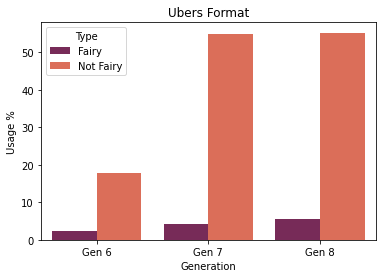

In [84]:
ubFairydf2= pd.DataFrame(
    {
        "Generation" : ['Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Fairy', 'Not Fairy', 'Fairy', 'Not Fairy','Fairy', 'Not Fairy'],
        "Usage %": [Fairy6ubusage, notFairy6ubusage, Fairy7ubusage, notFairy7ubusage,Fairy8ubusage, notFairy8ubusage],
    },
)
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ubFairydf2,
            palette='rocket'
           ).set_title("Ubers Format");

In [52]:
ouFairydf2= pd.DataFrame(
    {
        "Generation" : ['Gen 6', 'Gen 6','Gen 7', 'Gen 7','Gen 8', 'Gen 8'],
        "Type": ['Fairy', 'Not Fairy', 'Fairy', 'Not Fairy','Fairy', 'Not Fairy'],
        "Usage %": [Fairy6ouusage, notFairy6ouusage, Fairy7ouusage, notFairy7ouusage,Fairy8ouusage, notFairy8ouusage],
    },
)
sns.barplot(x="Generation", 
            y="Usage %", 
            hue="Type", 
            data=ouFairydf2,
            palette='rocket'
           ).set_title("OU Format");

NameError: name 'Fairy6ouusage' is not defined

In [23]:
usagemovesdf.head()

,name,Moves,Usage,Gen,Format,Min Rating,Recent,Type 1,Type 2,Type 3,Type 4,Type 5,Type 6,SE Dragon,SE Fairy
0,Bronzong,"['gyroball', 'explosion', 'earthquake', 'steal...",0.124514,4.0,ou,0.0,1,Steel,Normal,Ground,Rock,Psychic,Water,0,1
1,Swampert,"['earthquake', 'stealthrock', 'waterfall', 'ic...",0.120051,4.0,ou,0.0,1,Ground,Rock,Water,Ice,Ice,Normal,2,0
2,Snorlax,"['bodyslam', 'crunch', 'earthquake', 'curse', ...",0.040116,4.0,ou,0.0,1,Normal,Dark,Ground,Ghost,Psychic,Fire,0,0
3,Uxie,"['stealthrock', 'uturn', 'thunderwave', 'psych...",0.023561,4.0,ou,0.0,1,Rock,Bug,Electric,Psychic,Psychic,Psychic,0,0
4,Machamp,"['dynamicpunch', 'payback', 'bulletpunch', 'ic...",0.102777,4.0,ou,0.0,1,Fighting,Dark,Steel,Ice,Rock,Normal,1,1


In [65]:
# We are only looking at ou and ubers formats
usagemovesdf2 = usagemovesdf[(usagemovesdf['Format'] == 'ou') | (usagemovesdf['Format'] == 'ubers')] 

# We are looking at the % of moves SE against Dragons in both tiers
gen4SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Dragon'].count() *6)
gen5SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Dragon'].count() *6)
gen6SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Dragon'].count() *6)
gen7SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Dragon'].count() *6)
gen8SEDragons = usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Dragon'].count() *6)

# We are looking at the % of moves SE against Dragons in just Ubers
gen4SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen5SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen6SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen7SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

gen8SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)

# We are looking at the % of moves SE against Dragons in just OU
gen4SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen5SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen6SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen7SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)

gen8SEDragonsOU = usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ou')]['SE Dragon'].count() *6)




print(gen4SEDragons, gen5SEDragons, gen6SEDragons, gen7SEDragons, gen8SEDragons)

gen4SEDragonsUbers

0.11412429378531073 0.12471264367816091 0.09877354358300482 0.09765715611227094 0.08610435252771019


C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/1342714253.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen4SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)
C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/1342714253.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen4SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Dragon'].count() *6)
C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/1342714253.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen5SEDragonsUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['S

0.15517241379310345

Text(0.5, 1.0, 'Moves SE against dragon in Generations 4-8')

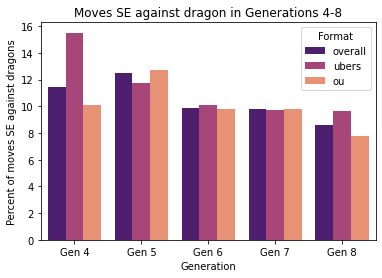

In [66]:
# EDA time woo

seDragonsDf = pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4','Gen 4', 'Gen 5', 'Gen 5','Gen 5', 'Gen 6', 'Gen 6','Gen 6','Gen 7', 'Gen 7','Gen 7','Gen 8', 'Gen 8', 'Gen 8'],
        "Format": ['overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou','overall', 'ubers', 'ou'],
        "Percent of moves SE against dragons": [gen4SEDragons, gen4SEDragonsUbers, gen4SEDragonsOU, gen5SEDragons, gen5SEDragonsUbers, gen5SEDragonsOU, gen6SEDragons, gen6SEDragonsUbers, gen6SEDragonsOU, gen7SEDragons, gen7SEDragonsUbers, gen7SEDragonsOU, gen8SEDragons, gen8SEDragonsUbers, gen8SEDragonsOU],
    },
)

seDragonsDf["Percent of moves SE against dragons"] = seDragonsDf["Percent of moves SE against dragons"].apply(lambda x: x*100)

sns.barplot(x="Generation", 
            y="Percent of moves SE against dragons", 
            hue="Format", 
            data=seDragonsDf,
            palette='magma'
           ).set_title("Moves SE against dragon in Generations 4-8")



In [67]:

# We are looking at the % of moves SE against Fairy in both tiers
gen4SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)]['SE Fairy'].count() *6)
gen5SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)]['SE Fairy'].count() *6)
gen6SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)]['SE Fairy'].count() *6)
gen7SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)]['SE Fairy'].count() *6)
gen8SEFairy = usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)]['SE Fairy'].count() *6)

# We are looking at the % of moves SE against Fairy in just Ubers
gen4SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen5SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen6SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen7SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

gen8SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)

# We are looking at the % of moves SE against Fairy in just OU
gen4SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen5SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen6SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 6)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen7SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 7)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

gen8SEFairyOU = usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 8)][(usagemovesdf2['Format'] == 'ou')]['SE Fairy'].count() *6)

C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/2113808878.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen4SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)
C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/2113808878.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen4SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].sum()/ (usagemovesdf2[(usagemovesdf2['Gen'] == 4)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].count() *6)
C:\Users\rjaki\AppData\Local\Temp/ipykernel_15240/2113808878.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen5SEFairyUbers = usagemovesdf2[(usagemovesdf2['Gen'] == 5)][(usagemovesdf2['Format'] == 'ubers')]['SE Fairy'].su

Text(0.5, 1.0, 'Moves SE against fairy in Generations 4-8')

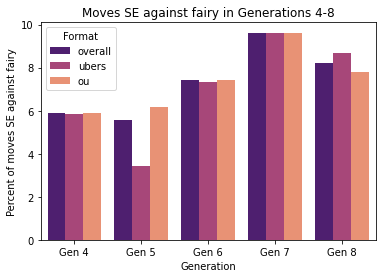

In [70]:
seFairyDf = pd.DataFrame(
    {
        "Generation" : ['Gen 4', 'Gen 4','Gen 4', 'Gen 5', 'Gen 5','Gen 5', 'Gen 6', 'Gen 6','Gen 6','Gen 7', 'Gen 7','Gen 7','Gen 8', 'Gen 8', 'Gen 8'],
        "Format": ['overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou', 'overall', 'ubers', 'ou','overall', 'ubers', 'ou'],
        "Percent of moves SE against fairy": [gen4SEFairy, gen4SEFairyUbers, gen4SEFairyOU, gen5SEFairy, gen5SEFairyUbers, gen5SEFairyOU, gen6SEFairy, gen6SEFairyUbers, gen6SEFairyOU, gen7SEFairy, gen7SEFairyUbers, gen7SEFairyOU, gen8SEFairy, gen8SEFairyUbers, gen8SEFairyOU],
    },
)

seFairyDf["Percent of moves SE against fairy"] = seFairyDf["Percent of moves SE against fairy"].apply(lambda x: x*100)

sns.barplot(x="Generation", 
            y="Percent of moves SE against fairy", 
            hue="Format", 
            data=seFairyDf,
            palette='magma'
           ).set_title("Moves SE against fairy in Generations 4-8")
